# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import mglearn

# Datasets

In [2]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
dfraw = pd.DataFrame(cancer['data'], columns=cancer['feature_names'])
dfraw = dfraw.loc[:, 'mean radius':'mean perimeter']  # use only first 3 features for simplicity

In [3]:
# add a categorical 'state' column (example: random assignment from a small set)
states = ['NY', 'CA', 'TX', 'FL', 'IL']
np.random.seed(0)
dfraw['state'] = pd.Categorical(np.random.choice(states, size=len(dfraw)))

product = ['a', 'b', 'c']
dfraw['product'] = pd.Categorical(np.random.choice(product, size=len(dfraw)))

In [4]:
dfraw['target'] = cancer['target']
# convert numeric target to categorical labels
dfraw['target'] = pd.Categorical(dfraw['target'])

dfraw

,mean radius,mean texture,mean perimeter,state,product,target
0,17.99,10.38,122.80,IL,b,0
1,20.57,17.77,132.90,NY,c,0
2,19.69,21.25,130.00,FL,a,0
3,11.42,20.38,77.58,FL,b,0
4,20.29,14.34,135.10,FL,a,0
...,...,...,...,...,...,...
564,21.56,22.39,142.00,FL,c,0
565,20.13,28.25,131.20,TX,a,0
566,16.60,28.08,108.30,TX,a,0
567,20.60,29.33,140.10,IL,b,0


# Data Partitioning

In [5]:
from sklearn.model_selection import train_test_split

dftemp=dfraw.drop(columns='target',inplace=False)
X_train, X_test, y_train, y_test = train_test_split(
    dftemp, dfraw['target'], stratify=cancer.target, random_state=42)

dftrain=pd.concat([X_train, y_train], axis=1)
X_train_orig = X_train.copy()
X_test_orig = X_test.copy()

print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_test shape: {}".format(y_test.shape))
print("dftrain shape: {}".format(dftrain.shape))

X_train shape: (426, 5)
X_test shape: (143, 5)
y_train shape: (426,)
y_test shape: (143,)
dftrain shape: (426, 6)


# Overall Analysis

In [6]:
# build dataframe summary with missing counts & percentages
dfsummary = pd.DataFrame({
    'Variable': dftrain.columns,
    'DataType': dftrain.dtypes.astype(str),
    'total_count': len(dftrain),
    'non_null_count': dftrain.notnull().sum().values,
    'missing_count': dftrain.isnull().sum().values,
    'missing_pct': (dftrain.isnull().mean() * 100).round(2).values,
    'n_unique': dftrain.nunique().values
})

# optional: include up to 3 sample values per column
dfsummary['samples'] = dftrain.apply(lambda s: s.dropna().unique()[:3].tolist()).values

dfsummary

,Variable,DataType,total_count,non_null_count,missing_count,missing_pct,n_unique,samples
mean radius,mean radius,float64,426,426,0,0.0,356,"[19.89, 12.89, 17.14]"
mean texture,mean texture,float64,426,426,0,0.0,373,"[20.26, 13.12, 16.4]"
mean perimeter,mean perimeter,float64,426,426,0,0.0,399,"[130.5, 81.89, 116.0]"
state,state,category,426,426,0,0.0,5,"[TX, NY, FL]"
product,product,category,426,426,0,0.0,3,"[c, a, b]"
target,target,category,426,426,0,0.0,2,"[0, 1]"


# EDA (Exploratory Data Analysis)

## Continuous-Continuous

In [7]:
dftrain.describe()

,mean radius,mean texture,mean perimeter
count,426.000000,426.000000,426.000000
mean,14.075202,19.295047,91.592911
std,3.508920,4.447806,24.184996
min,6.981000,9.710000,43.790000
25%,11.632500,15.990000,74.720000
50%,13.275000,18.825000,86.040000
75%,15.745000,21.795000,103.675000
max,28.110000,39.280000,188.500000


In [8]:
dfnum = dftrain.select_dtypes(include=['number'])
dfcorr = dfnum.corr().round(3)
dfcorr

,mean radius,mean texture,mean perimeter
mean radius,1.000,0.327,0.998
mean texture,0.327,1.000,0.330
mean perimeter,0.998,0.330,1.000


In [9]:
dfhicorr = dfcorr[(dfcorr.abs() > 0.7) & (dfcorr.abs() < 1)]
dfhicorr = dfhicorr.dropna(how='all').dropna(axis=1, how='all')
dfhicorr

,mean radius,mean perimeter
mean radius,NaN,0.998
mean perimeter,0.998,NaN


Text(0.5, 1.02, 'Pairplot with Correlation in Upper Triangle')

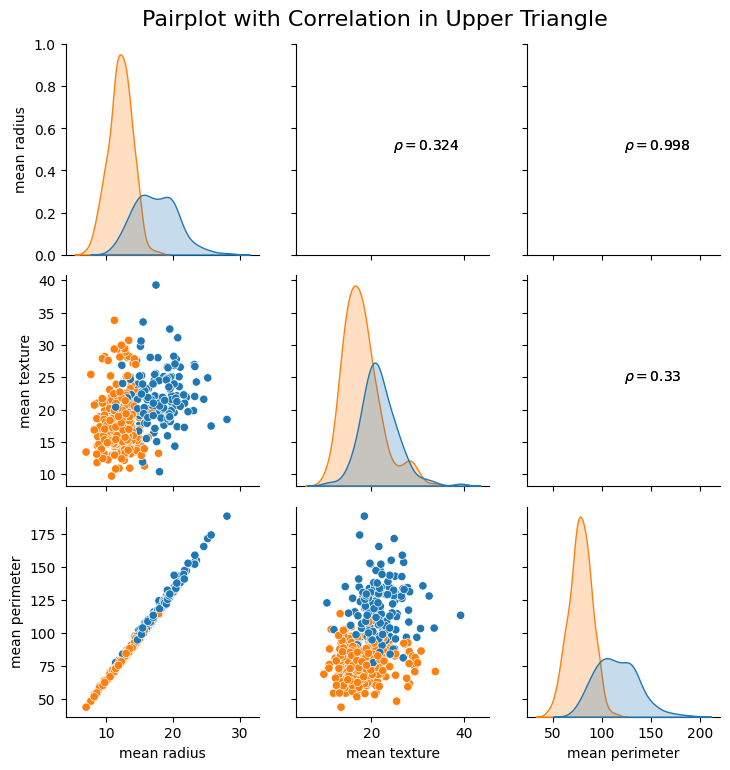

In [10]:
g = sns.PairGrid(dftrain, hue='target',diag_sharey=False)

def corrfunc(x, y, **kws):
    # r = np.corrcoef(x, y)[0][1]
    # dftemp=pd.DataFrame(data={'x':x, 'y':y})
    # r = dftemp.corr().round(3).iloc[0,1]
    
    r = dfraw[[x.name, y.name]].corr().iloc[0, 1].round(3)

    ax = plt.gca()
    # ax.clear()
    # ax.spines['left'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)
    # ax.set_xticks([])
    # ax.set_yticks([])
    ax.text(.5,.5,f"$\\rho = {r}$",transform=ax.transAxes)

g.map_upper(corrfunc) 
g.map_diag(sns.kdeplot, fill=True)
g.map_lower(sns.scatterplot)

# Add title
g.fig.suptitle('Pairplot with Correlation in Upper Triangle', fontsize=16, y=1.02)

## Categorical-Categorical

<>:29: SyntaxWarning: invalid escape sequence '\c'
<>:29: SyntaxWarning: invalid escape sequence '\c'
C:\Users\ChaudharyVimal\AppData\Local\Temp\ipykernel_29424\4094426207.py:29: SyntaxWarning: invalid escape sequence '\c'
  axs[i,j].text(.4,.4,f"$\chi^2 = {chi2:.2f}$" + "\n" f"p-value = {p:.2f}" + "\n" f"df = {dof:.2f}",


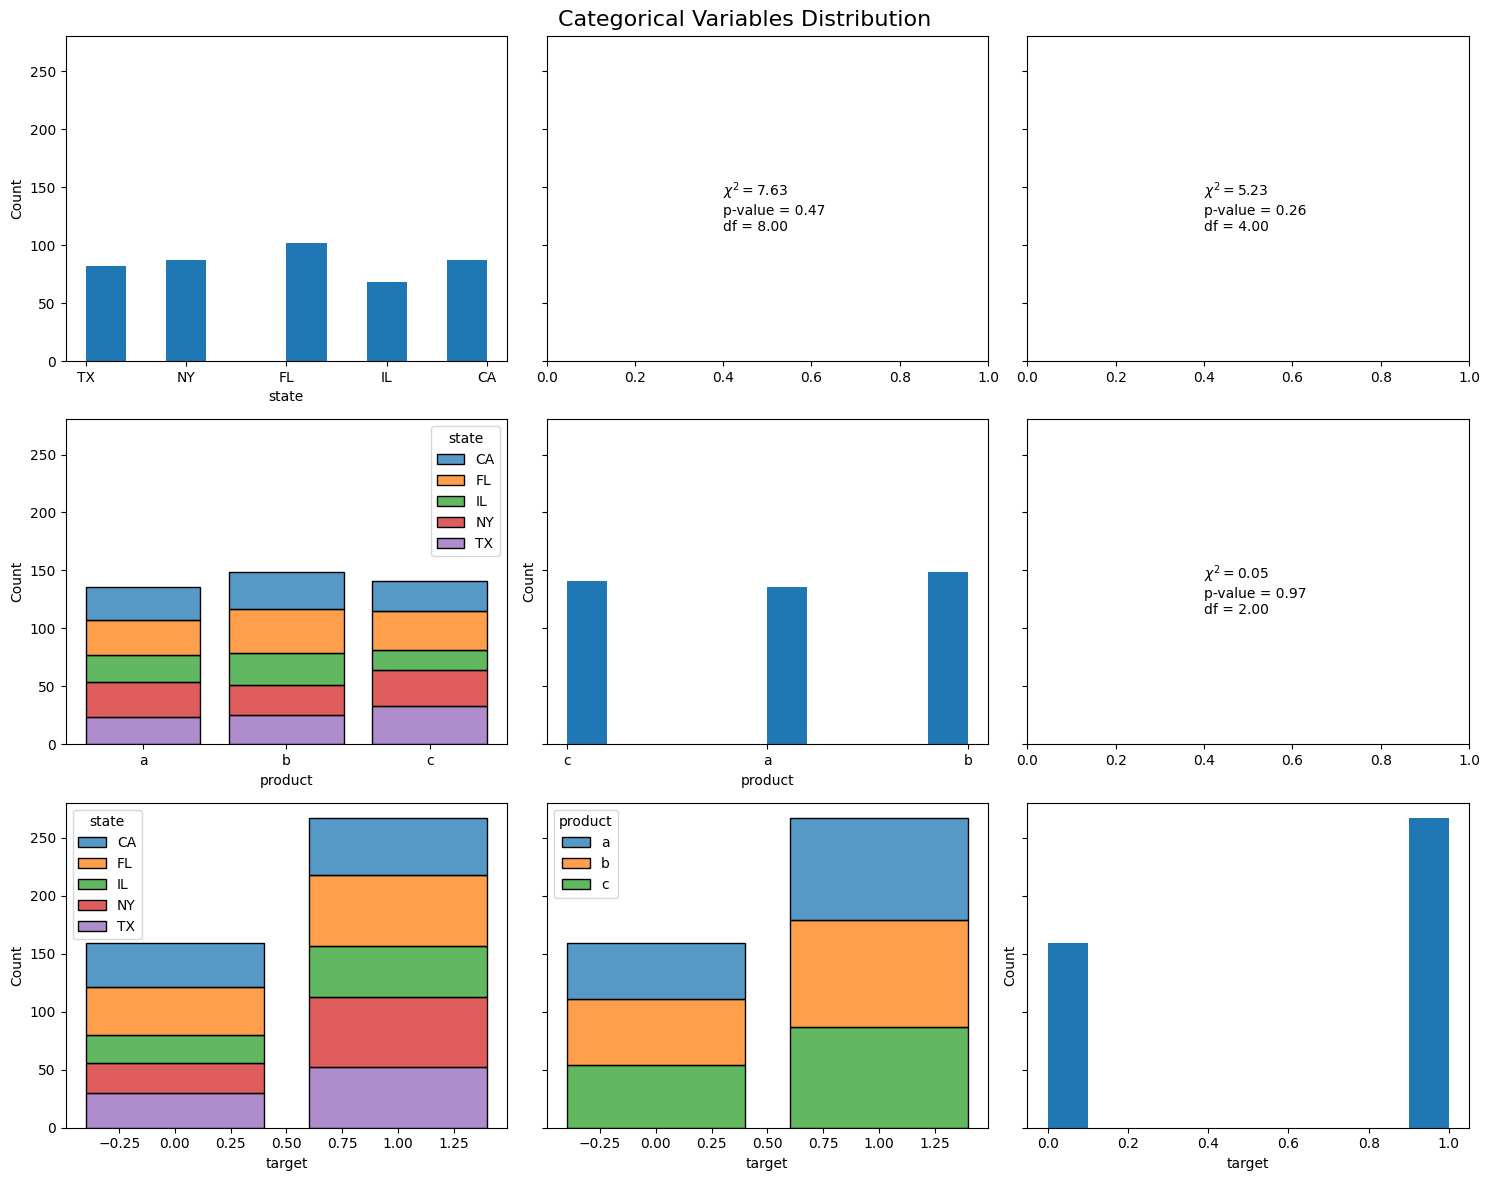

In [11]:
dfcat = dftrain.select_dtypes(include=['object', 'category']).columns.tolist()

#dfcat = dfsummary[dfsummary['DataType'].isin(['category'])]

fig, axs = plt.subplots(nrows=len(dfcat),ncols = len(dfcat), figsize=(5*len(dfcat),4*len(dfcat)),sharey=True)
for i, col in enumerate(dfcat):
    for j in range(len(dfcat)):
        if i==j:
            axs[i,j].hist(data=dftrain[dfcat], x=col)
            # sns.histplot(data=df, x=col, multiple='stack', stat='proportion')
            axs[i,j].set_xlabel(col)
            axs[i,j].set_ylabel('Count')
        elif i>j:
            # axs[i,j].hist(data=df[dfcat], x=col, stacked=True)
            sns.histplot(
                data=dftrain,
                x=col,
                hue=dfcat[j],            # stack by this categorical column
                multiple="stack",
                stat="count",
                shrink=0.8,
                ax=axs[i, j]
            )
            axs[i,j].set_xlabel(col)
            axs[i,j].set_ylabel('Count')
        elif i<j:
            contingency_table = pd.crosstab(dfraw[col], dfraw[dfcat[j]])
            chi2, p, dof, expected = chi2_contingency(contingency_table)
            axs[i,j].text(.4,.4,f"$\chi^2 = {chi2:.2f}$" + "\n" f"p-value = {p:.2f}" + "\n" f"df = {dof:.2f}",
            transform=axs[i,j].transAxes)


fig.suptitle('Categorical Variables Distribution', fontsize=16)
plt.tight_layout()

## Continuous-Categorical

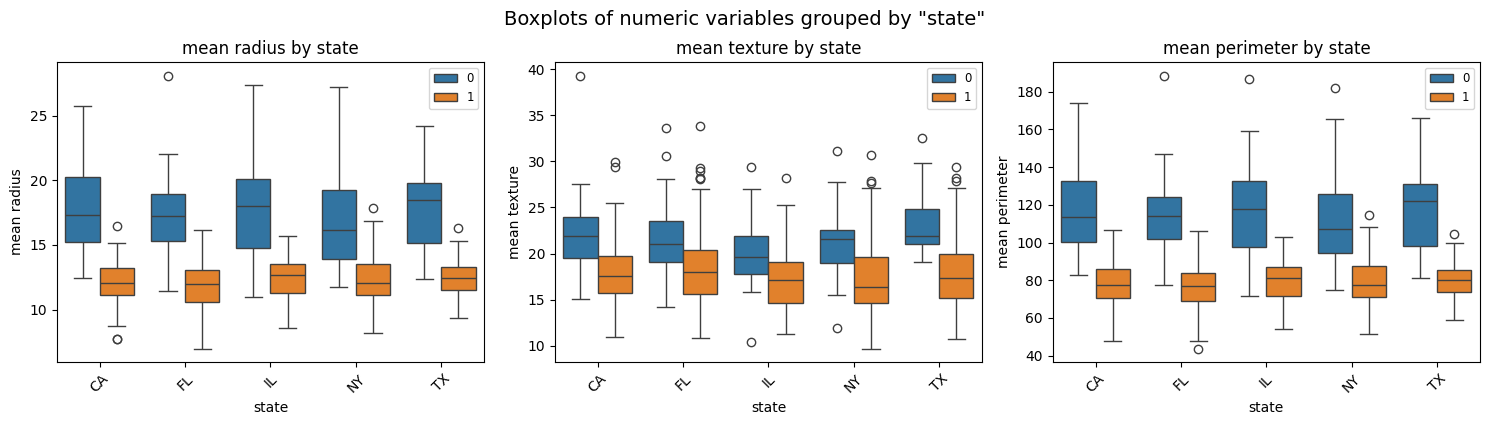

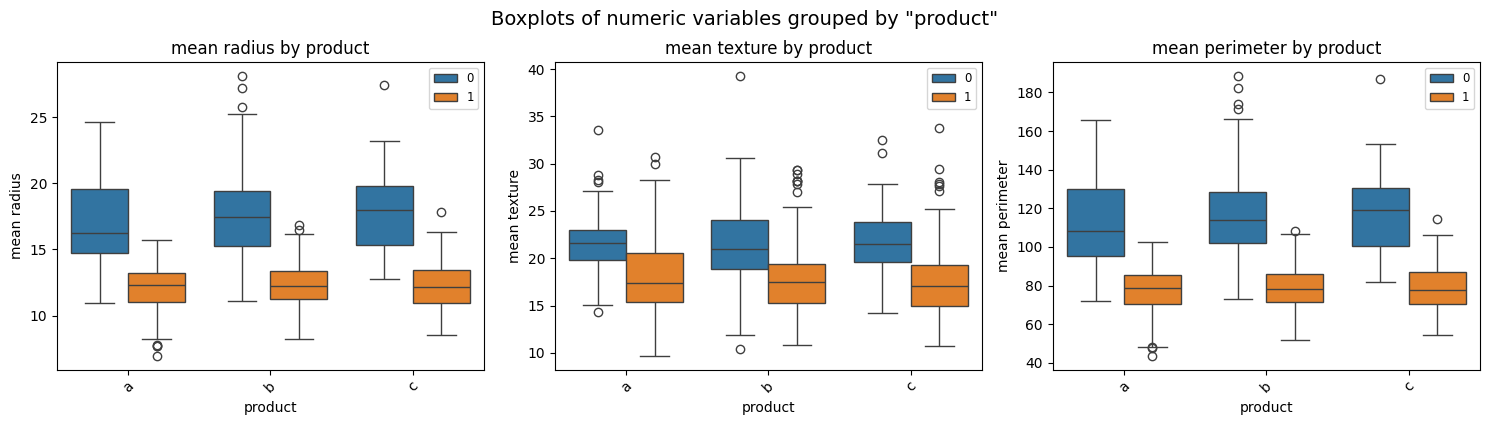

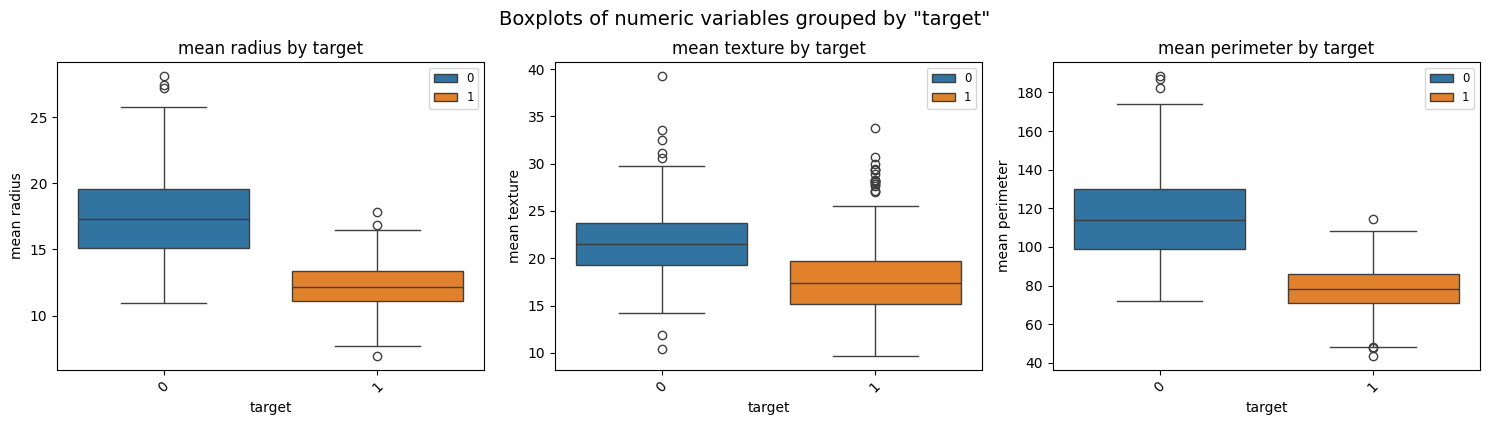

In [12]:
import math

dfnum = dftrain.select_dtypes(include=['number']).columns.tolist()
# cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

if len(dfnum) == 0 or len(dfcat) == 0:
    print("Need at least one numeric and one categorical column.")
else:
    for cat in dfcat:
        n = len(dfnum)
        ncols = 3
        nrows = math.ceil(n / ncols)
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows), squeeze=False)
        axs_flat = axs.flatten()

        for i, num in enumerate(dfnum):
            ax = axs_flat[i]
            if 'target' in dfraw.columns:
                sns.boxplot(data=dfraw, x=cat, y=num, hue='target', ax=ax)
                ax.legend(loc='upper right', fontsize='small')
            else:
                sns.boxplot(data=dfraw, x=cat, y=num, ax=ax)
            ax.set_title(f"{num} by {cat}")
            ax.tick_params(axis='x', rotation=45)

        # turn off any unused subplots
        for j in range(n, len(axs_flat)):
            axs_flat[j].axis('off')

        fig.suptitle(f'Boxplots of numeric variables grouped by "{cat}"', fontsize=14, y=1.05)
        plt.tight_layout()
        fig.subplots_adjust(top=0.92)


# Missing Value Treatment

In [13]:
# Drop columns with >5% missing values
cols_to_drop = dfsummary.loc[dfsummary['missing_pct']>.05,"Variable"].to_list()
dftrainmv = dftrain.drop(columns=cols_to_drop)
dftrainmv

,mean radius,mean texture,mean perimeter,state,product,target
517,19.890,20.26,130.50,TX,c,0
287,12.890,13.12,81.89,NY,a,1
25,17.140,16.40,116.00,FL,a,0
253,17.300,17.08,113.00,FL,b,0
369,22.010,21.90,147.20,FL,a,0
...,...,...,...,...,...,...
184,15.280,22.41,98.92,FL,c,0
300,19.530,18.90,129.50,IL,a,0
509,15.460,23.95,103.80,CA,a,0
230,17.050,19.08,113.40,CA,c,0


In [14]:
# Impute columns wuth <5% missing values

# num columns
dfnum = dftrainmv.select_dtypes(include=['number']).columns.tolist()
for i, var in enumerate(dfnum):
    dftrainmv[var].fillna(dftrainmv[var].mean(), inplace=True) 

# cat columns
dfcat = dftrainmv.select_dtypes(include=['object', 'category']).columns.tolist()
for i, var in enumerate(dfnum):
    dftrainmv[var].fillna(dftrainmv[var].mode()[0], inplace=True)

dftrainmv

C:\Users\ChaudharyVimal\AppData\Local\Temp\ipykernel_29424\1575194332.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dftrainmv[var].fillna(dftrainmv[var].mean(), inplace=True)
C:\Users\ChaudharyVimal\AppData\Local\Temp\ipykernel_29424\1575194332.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alway

,mean radius,mean texture,mean perimeter,state,product,target
517,19.890,20.26,130.50,TX,c,0
287,12.890,13.12,81.89,NY,a,1
25,17.140,16.40,116.00,FL,a,0
253,17.300,17.08,113.00,FL,b,0
369,22.010,21.90,147.20,FL,a,0
...,...,...,...,...,...,...
184,15.280,22.41,98.92,FL,c,0
300,19.530,18.90,129.50,IL,a,0
509,15.460,23.95,103.80,CA,a,0
230,17.050,19.08,113.40,CA,c,0


# Outlier Treatment

# VIF

In [15]:
# VIF Calculation using sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def calculate_vif_sklearn(df):
    # Select numeric columns
    dfnum = df.select_dtypes(include=['number'])
    
    vif_data = []
    for i in range(dfnum.shape[1]):
        y = dfnum.iloc[:, i]
        X = dfnum.drop(dfnum.columns[i], axis=1)
        
        # Fit linear regression
        model = LinearRegression()
        model.fit(X, y)
        
        # Compute R²
        r2 = model.score(X, y)
        
        # Compute VIF
        vif = 1 / (1 - r2) if r2 < 1 else float('inf')
        vif_data.append((dfnum.columns[i], vif))
    
    return pd.DataFrame(vif_data, columns=['feature', 'VIF'])

dftrainvif = calculate_vif_sklearn(dftrainmv)
dftrainvif

,feature,VIF
0,mean radius,235.748640
1,mean texture,1.122978
2,mean perimeter,236.206153


In [16]:
# Drop columns with high VIF
def drop_high_vif(df, threshold=10):
    # dftemp=df.copy()

    
    while True:
        dfnum = df.select_dtypes(include=['number'])
        dfvif = calculate_vif_sklearn(dfnum)
        max_vif = dfvif['VIF'].max()
        if max_vif <= threshold:
            break
        drop_col = dfvif.loc[dfvif['VIF'].idxmax(), 'feature']
        print(f"Dropping column '{drop_col}' with VIF={max_vif:.2f}")
        df = df.drop(columns=[drop_col])
    return df, dfvif

dftrainvif, dffinalvif = drop_high_vif(dftrainmv, threshold=10)

Dropping column 'mean perimeter' with VIF=236.21


In [17]:
dftrainvif

,mean radius,mean texture,state,product,target
517,19.890,20.26,TX,c,0
287,12.890,13.12,NY,a,1
25,17.140,16.40,FL,a,0
253,17.300,17.08,FL,b,0
369,22.010,21.90,FL,a,0
...,...,...,...,...,...
184,15.280,22.41,FL,c,0
300,19.530,18.90,IL,a,0
509,15.460,23.95,CA,a,0
230,17.050,19.08,CA,c,0


# IV

In [18]:
# IV Calculation
def calculate_iv(df, target, bins=10):
    iv_dict = {}
    for col in df.columns:
        if col == target:
            continue
        # Handle numeric vs categorical
        if pd.api.types.is_numeric_dtype(df[col]):
            binned= pd.qcut(df[col], bins, duplicates='drop')
            groups = df.groupby(binned,observed=True)
        else:
            groups = df.groupby(col,observed=True)
        
        # Calculate WOE and IV
        iv = 0
        for grp, subset in groups:
            good = (subset[target] == 0).sum()
            bad = (subset[target] == 1).sum()
            total_good = (df[target] == 0).sum()
            total_bad = (df[target] == 1).sum()
            
            if good == 0 or bad == 0:
                continue  # Avoid division by zero
            
            dist_good = good / total_good
            dist_bad = bad / total_bad
            woe = np.log(dist_good / dist_bad)
            iv += (dist_good - dist_bad) * woe
        
        iv_dict[col] = iv
        # df = df.drop(columns=[col+'_bin'], inplace=True, errors='ignore')
        
    return pd.DataFrame(list(iv_dict.items()), columns=['feature', 'IV']).sort_values(by='IV', ascending=False)

dftrainiv = calculate_iv(dftrainvif, target='target')
dftrainiv


,feature,IV
0,mean radius,2.656503
1,mean texture,1.267125
2,state,0.041337
3,product,0.003554


In [19]:
# Drop columns with IV < threshold
def drop_low_iv(df, target, threshold=0.02, bins=10):
    iv_df = calculate_iv(df, target, bins)
    low_iv_cols = iv_df[iv_df['IV'] < threshold]['feature'].tolist()
    
    print(f"Dropping columns with IV < {threshold}: {low_iv_cols}")
    
    df.drop(columns=low_iv_cols, inplace=True)
    return df, iv_df


dftrainiv, iv_table = drop_low_iv(dftrainvif, target='target', threshold=0.02)
dftrainiv


Dropping columns with IV < 0.02: ['product']


,mean radius,mean texture,state,target
517,19.890,20.26,TX,0
287,12.890,13.12,NY,1
25,17.140,16.40,FL,0
253,17.300,17.08,FL,0
369,22.010,21.90,FL,0
...,...,...,...,...
184,15.280,22.41,FL,0
300,19.530,18.90,IL,0
509,15.460,23.95,CA,0
230,17.050,19.08,CA,0


# Models

## kNN

In [20]:
X_train = dftrainiv.drop(columns='target').select_dtypes(include=['number'])
X_test = X_test[X_train.columns]  # ensure test set has same features as train set
y_train = dftrainiv['target']

print("X_train shape is {}".format(X_train.shape))
print("X_test shape is {}".format(X_test.shape))
print("y_train shape is {}".format(y_train.shape))


X_train shape is (426, 2)
X_test shape is (143, 2)
y_train shape is (426,)


In [21]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

ypred = knn.predict_proba(X_test)
print("ypred shape is {}".format(ypred.shape))
ypred[0:9,:]

print("Test set score: {:.2f}".format(knn.score(X_test, y_test)))

ypred shape is (143, 2)
Test set score: 0.90


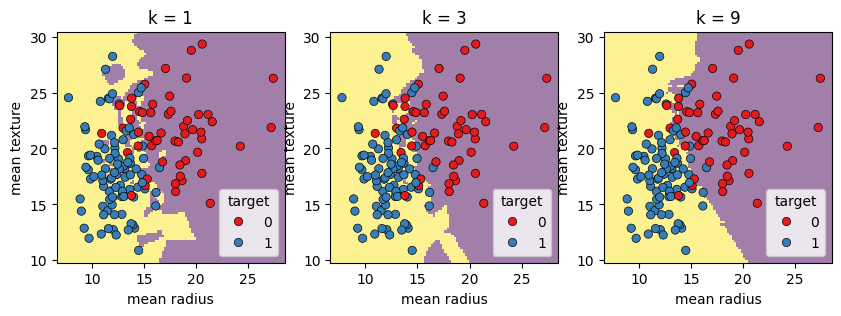

In [22]:
from sklearn.inspection import DecisionBoundaryDisplay

fig, axes = plt.subplots(1, 3, figsize=(10, 3))

for n_neighbors, ax in zip([1, 3, 9], axes):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X_train, y_train)
    
    disp = DecisionBoundaryDisplay.from_estimator(
        knn,
        X_test.iloc[:, 0:2],
        response_method="predict",
        plot_method="pcolormesh",
        xlabel=X_test.columns[0],
        ylabel=X_test.columns[1],
        shading="auto",
        alpha=0.5,
        ax=ax
    )

    sns.scatterplot(
        x=X_test.iloc[:, 0],
        y=X_test.iloc[:, 1],
        hue=y_test,
        palette='Set1',
        edgecolor='k',
        ax=ax
    )

    ax.set_title(f"k = {n_neighbors}")

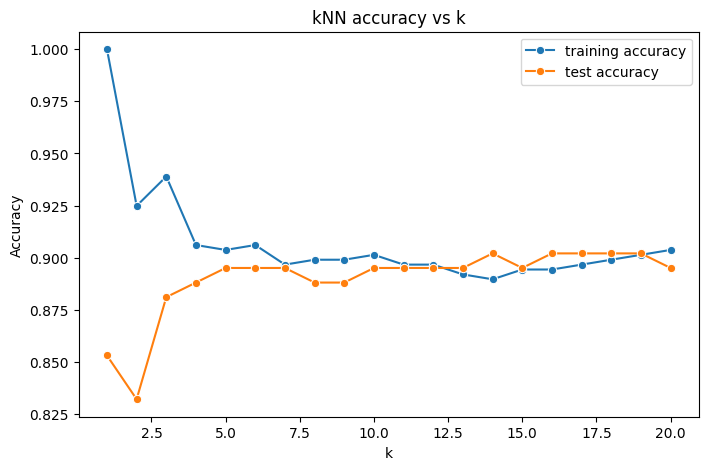

In [23]:
training_accuracy = []
test_accuracy = []
# try different n_neighbors
k = range(1, 21)
for n_neighbors in k:
    # build the model
    knn = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(knn.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(knn.score(X_test, y_test))

# k=list(k)
# reciprocal_values = [1 / x for x in k]



plt.figure(figsize=(8, 5))
sns.lineplot(x=k, y=training_accuracy, marker='o', label='training accuracy')
sns.lineplot(x=k, y=test_accuracy, marker='o', label='test accuracy')
# sns.relplot(x=reciprocal_values, y=training_accuracy, kind="line", label="training accuracy")
# sns.relplot(x=reciprocal_values, y=test_accuracy, kind="line", label="test accuracy")
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('kNN accuracy vs k')
plt.legend()

## Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression

X_train_temp = X_train_orig.drop(columns= ["product","state"])
X_test_temp = X_test_orig.drop(columns= ["product","state"])

logreg = LogisticRegression().fit(X_train_temp, y_train)
print("Training set score: {:.3f}".format(logreg.score(X_train_temp, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test_temp, y_test)))

Training set score: 0.904
Test set score: 0.930


In [68]:
# Decision Function
## shape (n_samples,)
## -ve -> Class0, +ve -> Class1
## Range is arbitrary
logreg.decision_function(X_test_temp)[:10]  # show the first 10 entries

array([ 2.56876684, -3.66415635, -0.19948781,  2.14241667, -0.62403141,
       -6.37773248,  1.32900121, -4.38521842, -6.1338684 ,  4.69230021])

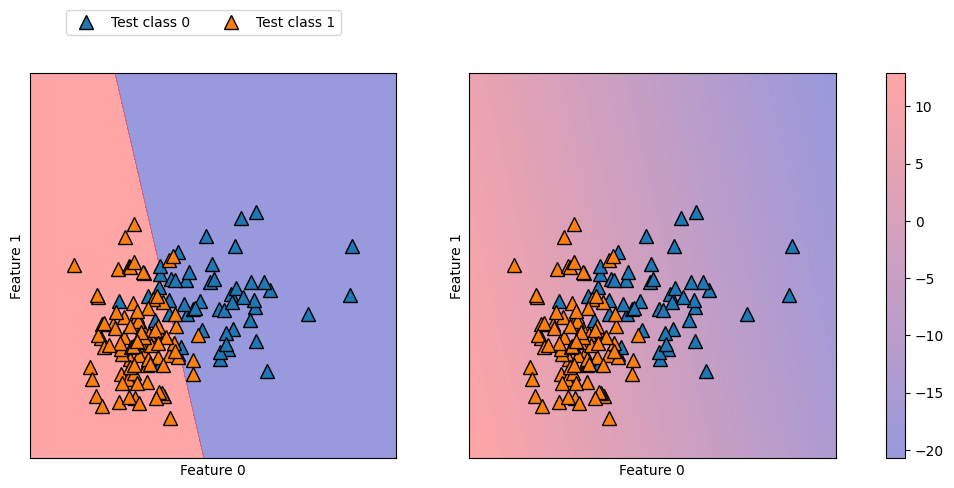

In [ ]:
#Decision Function contours, imshow
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

dfraw_temp = dfraw.iloc[:,0:2].to_numpy() 
X_train_temp = X_train_orig.iloc[:,0:2].to_numpy()
X_test_temp = X_test_orig.iloc[:,0:2].to_numpy()
logreg = LogisticRegression().fit(X_train_temp, y_train)

mglearn.tools.plot_2d_separator(logreg, X_train_temp, ax=axes[0], alpha=.4,fill=True, cm=mglearn.cm2)
scores_image = mglearn.tools.plot_2d_scores(logreg, X_train_temp, ax=axes[1],alpha=.4, cm=mglearn.ReBl)
for ax in axes:
    # plot training and test points
    mglearn.discrete_scatter(X_test_temp[:, 0], X_test_temp[:, 1], y_test,markers='^', ax=ax)
    # mglearn.discrete_scatter(X_train_temp[:, 0], X_train_temp[:, 1], y_train,markers='o', ax=ax)
    ax.set_xlabel("Feature 0")
    ax.set_ylabel("Feature 1")
cbar = plt.colorbar(scores_image, ax=axes.tolist())
axes[0].legend(["Test class 0", "Test class 1", "Train class 0","Train class 1"], ncol=4, loc=(.1, 1.1))

In [66]:
# Binary classification
# - shape (n_samples,2)
# - max prob -> likely class
# - Range [0,1]

# show the first few entries of predict_proba
print("Predicted probabilities:\n{}".format(
logreg.predict_proba(X_test_temp[:6])))

Predicted probabilities:
[[0.07117579 0.92882421]
 [0.97501449 0.02498551]
 [0.54970722 0.45029278]
 [0.10504199 0.89495801]
 [0.65113487 0.34886513]
 [0.99830391 0.00169609]]


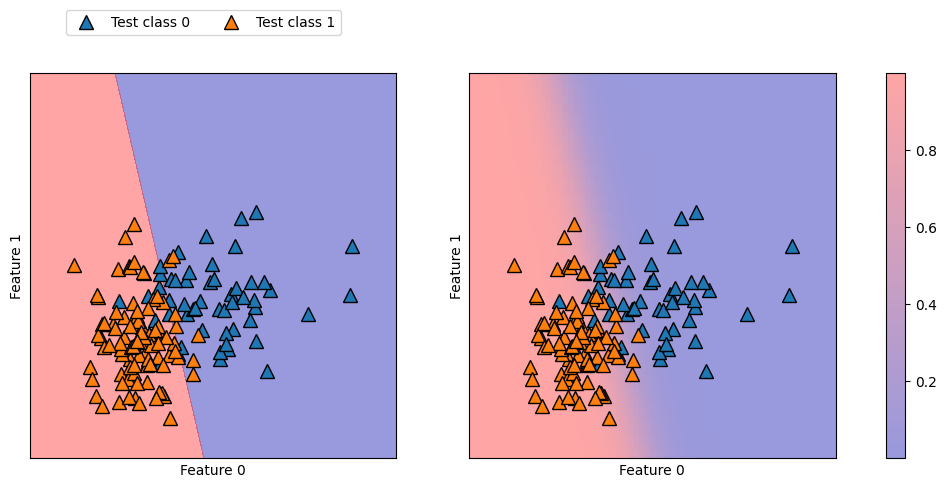

In [71]:
# Predict_proba Function contours, imshow
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

dfraw_temp = dfraw.iloc[:,0:2].to_numpy() 
X_train_temp = X_train_orig.iloc[:,0:2].to_numpy()
X_test_temp = X_test_orig.iloc[:,0:2].to_numpy()
logreg = LogisticRegression().fit(X_train_temp, y_train)

mglearn.tools.plot_2d_separator(logreg, X_train_temp, ax=axes[0], alpha=.4,fill=True, cm=mglearn.cm2)
scores_image = mglearn.tools.plot_2d_scores(logreg, X_train_temp, ax=axes[1],alpha=.4, cm=mglearn.ReBl,
function='predict_proba')
for ax in axes:
    # plot training and test points
    mglearn.discrete_scatter(X_test_temp[:, 0], X_test_temp[:, 1], y_test,markers='^', ax=ax)
    # mglearn.discrete_scatter(X_train_temp[:, 0], X_train_temp[:, 1], y_train,markers='o', ax=ax)
    ax.set_xlabel("Feature 0")
    ax.set_ylabel("Feature 1")
cbar = plt.colorbar(scores_image, ax=axes.tolist())
axes[0].legend(["Test class 0", "Test class 1", "Train class 0","Train class 1"], ncol=4, loc=(.1, 1.1))

In [25]:
logreg100 = LogisticRegression(C=100).fit(X_train_temp, y_train)
print("Training set score: {:.3f}".format(logreg100.score(X_train_temp, y_train)))
print("Test set score: {:.3f}".format(logreg100.score(X_test_temp, y_test)))

Training set score: 0.915
Test set score: 0.930


## SVM

In [26]:
from sklearn.svm import LinearSVC

linear_svm = LinearSVC().fit(X_train_temp, y_train)
print("Coefficient shape: ", linear_svm.coef_.shape)
print("Intercept shape: ", linear_svm.intercept_.shape)

print("Training set score: {:.3f}".format(logreg.score(X_train_temp, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test_temp, y_test)))

Coefficient shape:  (1, 3)
Intercept shape:  (1,)
Training set score: 0.904
Test set score: 0.930


Text(0.5, 1.0, 'Linear SVM Decision Boundary')

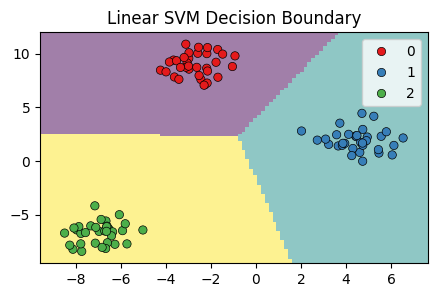

In [27]:
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.datasets import make_blobs
X, y = make_blobs(random_state=42)

fig, ax = plt.subplots( figsize=(5, 3))

linear_svm = LinearSVC().fit(X, y)

disp = DecisionBoundaryDisplay.from_estimator(
    linear_svm,
    X,
    response_method="predict",
    plot_method="pcolormesh",
    # xlabel=X.columns[0],
    # ylabel=X.columns[1],
    shading="auto",
    alpha=0.5,
    ax=ax
)

sns.scatterplot(
    x=X[:, 0],
    y=X[:, 1],
    hue=y,
    palette='Set1',
    edgecolor='k',
    ax=ax
)

ax.set_title(f"Linear SVM Decision Boundary")

## Trees

In [28]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=4, random_state=0)
tree.fit(X_train_temp, y_train)
print("Accuracy on training set: {:.3f}".format(tree.score(X_train_temp, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test_temp, y_test)))

Accuracy on training set: 0.932
Accuracy on test set: 0.881


In [29]:
from sklearn.tree import export_graphviz
export_graphviz(tree, out_file="tree.dot", class_names=["malignant", "benign"],
    # feature_names=X_train_temp.feature_names, 
    impurity=False, filled=True)



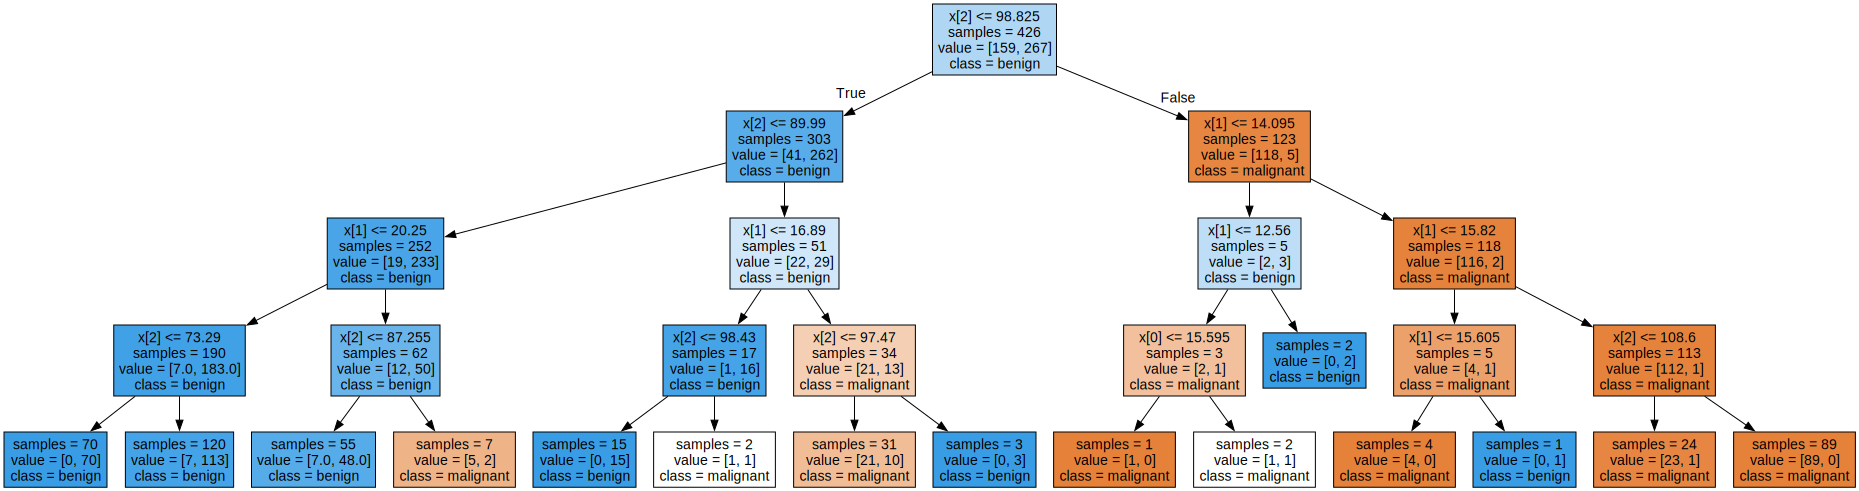

In [30]:
import graphviz
with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [31]:
print("Feature importances:\n{}".format(tree.feature_importances_))

Feature importances:
[0.00217033 0.1019113  0.89591836]


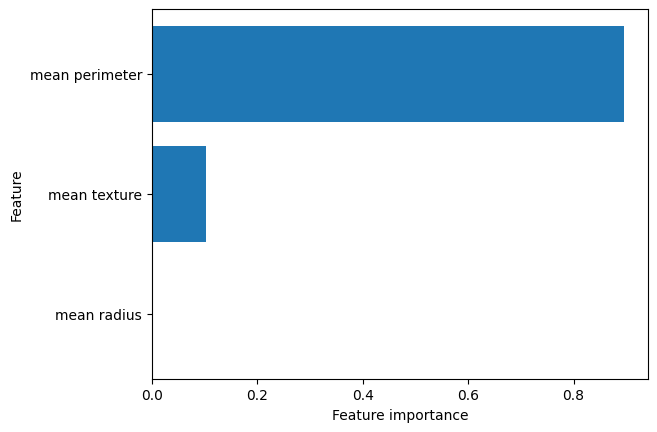

In [38]:
def plot_feature_importances_cancer(model):
    n_features = X_test_temp.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features)
    , X_test_temp.columns
    )
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
plot_feature_importances_cancer(tree)

In [ ]:
# StandardScaler - z = (x - u) / s (transformed data has µ=0, σ =1)
# RobustScaler   - x_trans = (x - x_median) / IQR
# MinMaxScaler   - x_trans = (x - min) / (max-min)
# Normalizer     - rescales so Euclidean length =1, useful when angle (direction) is imp and not length (magnitude)?





# Rough

In [ ]:
#Confusion matrix, AUC curve, cat variables, feature importance etc.
# Trees - elbow chart b/w tree size and accuracy, pruning   
# standardizzation, hyperparameter tuning, pipelines etc.



In [13]:
S = mglearn.datasets.make_signals()
A = np.random.RandomState(0).uniform(size=(100, 3))
A

array([[0.5488135 , 0.71518937, 0.60276338],
       [0.54488318, 0.4236548 , 0.64589411],
       [0.43758721, 0.891773  , 0.96366276],
       [0.38344152, 0.79172504, 0.52889492],
       [0.56804456, 0.92559664, 0.07103606],
       [0.0871293 , 0.0202184 , 0.83261985],
       [0.77815675, 0.87001215, 0.97861834],
       [0.79915856, 0.46147936, 0.78052918],
       [0.11827443, 0.63992102, 0.14335329],
       [0.94466892, 0.52184832, 0.41466194],
       [0.26455561, 0.77423369, 0.45615033],
       [0.56843395, 0.0187898 , 0.6176355 ],
       [0.61209572, 0.616934  , 0.94374808],
       [0.6818203 , 0.3595079 , 0.43703195],
       [0.6976312 , 0.06022547, 0.66676672],
       [0.67063787, 0.21038256, 0.1289263 ],
       [0.31542835, 0.36371077, 0.57019677],
       [0.43860151, 0.98837384, 0.10204481],
       [0.20887676, 0.16130952, 0.65310833],
       [0.2532916 , 0.46631077, 0.24442559],
       [0.15896958, 0.11037514, 0.65632959],
       [0.13818295, 0.19658236, 0.36872517],
       [0.